<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/Barrons_2021_picks_Tracker_(with_Markowitz_Portfolios).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking Barrons "best picks for 2021" as Markowitz portfolios

We analyse how Barrons "best" picks for 2021 performed in 2021 versus a Benchmark.

However, rather than use a simple Equal-Weighted portfolio, we will attempt to build a portfolio with the optimum number of shares per stock. We do this using Modern Portfolio Theory (Markowitz Portfolio Theory) by constructing the Efficient Frontier and picking out the the MSR (Maximum Sharpe Ratio) and GMV (Global Minimum Variance) portfolios.



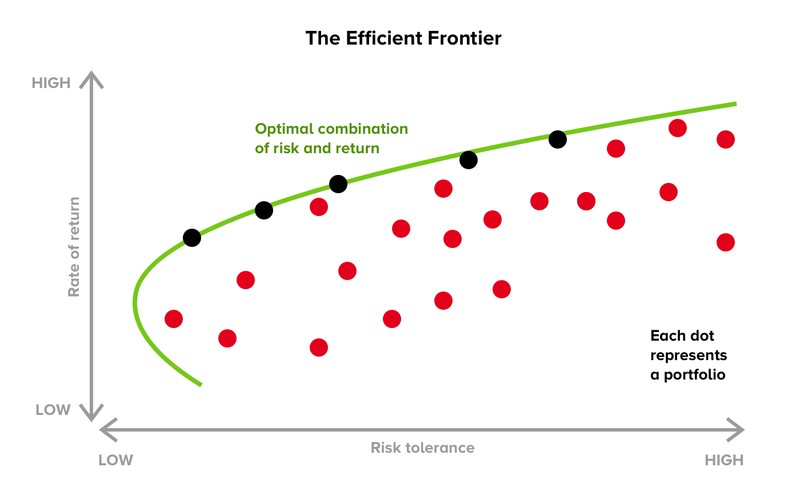


We do this by generating 100,000 portfolio weights randomly and plot their returns vs volatility. As per MPT a curve will apear "Efficient Frontier" from scratch and pick out and measure their performance as well.
The questions we are asking are as follows

1. Does the Efficient Frontier Emerge ?
2. Are the Barron's stock picks any good ?
3. In what 'style' of porfolio do the Barron's stock picks perform best -
4. Does the style of portfolio have any effect on the pick ?

You can see the Barron's article with the stock picks here (paywall alert !)

The Barrons Stock Pics are as follows
- Alphabet - GOOGL
- Apple - AAPL
- Berkshire Hathaway - BRK.A
- Coca Cola - KO
- Eaton - ETN
- Goldman Sachs Group - GS
- Graham Holdings - GHC
- Madison Square Entertainment - MSGE
- Merck - MRK
- Newmont - NEM

In [ ]:
#optinal installs 
!pip install yfinance

In [28]:
#imports
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Initilizing dates, portfolio, variables and getting stock prices from yahoo.

In [29]:
#start time is Jan 1st 2021 and the end time is a few months out in 2022 to see how the portfolio looks.
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,4,1)

#Portfolios
portfolio1 = ['AAPL', 'BRK-A', 'ETN', 'GHC', 'GOOGL', 'GS', 'KO', 'MRK', 'MSGE', 'NEM']

#get stock prices of portfolio components from yahoo
portfolio_df_1 = yf.download(portfolio1,start=start,end=end)['Adj Close']
#let's see what the stock price data looks like
print(portfolio_df_1.head())

#percentage change aka returns
portfolio_df_1_pctChg = portfolio_df_1.pct_change()

numstocks = len(portfolio1)



[*********************100%***********************]  10 of 10 completed
                  AAPL     BRK-A         ETN         GHC        GOOGL  \
Date                                                                    
2021-01-04  128.453445  343525.0  115.807861  519.361389  1726.130005   
2021-01-05  130.041595  341820.0  117.036644  522.027771  1740.050049   
2021-01-06  125.664223  346189.0  123.317093  531.389709  1722.880005   
2021-01-07  129.952286  350089.0  125.891670  532.604370  1774.339966   
2021-01-08  131.073929  352039.0  123.736435  542.825500  1797.829956   

                    GS         KO        MRK        MSGE        NEM  
Date                                                                 
2021-01-04  258.902100  50.758961  73.887581  100.239998  60.456375  
2021-01-05  264.695587  50.200958  74.015358   98.050003  60.724430  
2021-01-06  278.979187  48.603916  75.183533  102.500000  62.457218  
2021-01-07  284.938812  48.065159  76.680275  102.260002  62.361492

## Portfolio Construction.

Since the goal of this exercise is to use Markowitz portfolios, we begin by generate 100,000 combinations of porfolio weights randomly. 

- The alogorithm for this is as follows:

First we generate ***n*** random numbers, where n is the number of stocks in the portfolio and then divide by the sum which normalizes them to 1

eg: randoms = [0.4, 0.7, 0.9, 0.3]  
sum of randoms = 2.3  
randoms / sum = [0.17,0.3,0.39,0.13] 
sum(randoms / sum) = 1





### A note about Expected returns

Its important to remember that for the Markowitz portfolio "Efficient Curve" the y-axis is ***Expected*** return. 

- Expected return  is the profit or loss one may expect to see from an investment.  To calculate the expected rate of return on a stock, you need to think about the different scenarios in which the stock could see a gain or loss. For each scenario, multiple that amount of gain or loss (return) by the probability of it happening. Finally, add up the numbers you get from each scenario after multiplying the returns by the probabilities. 

- However its hard to always calculate or know these probabilities and so in practice, we determine the expected rate of return based on historical data, we do this by calculating the average of the historical return for that investment. **Bear in mind that historical data is a guide, it’s not necessarily predictive.**

For this exercise, we will use historical averages to calculate Expected Returns.

In [53]:
#we create empty lists to hold results of the simulation
portfolio_exp_returns = []
portfolio_vol = []
port_weights = []

num_of_simulated_portfolios = 100000

We start the process of constructing the 10,000 random weight portfolios and keeping track of them

- When calculating Expected returns, we check to see if our holding period is for more than a year or not. If more then a year, we re-sample it to a yearly basis, if not we annualize.

In [54]:
#start loop here--------
for port in range(num_of_simulated_portfolios):
    
    #algorithm to generate random weights
    weights  = np.random.random(numstocks)
    portfolio_weights = weights/np.sum(weights)
    #keep track of these weights
    port_weights.append(portfolio_weights)
    
    #calculate portfolio Returns 
    port_ret=portfolio_df_1_pctChg.iloc[:,0:numstocks].mul(portfolio_weights,axis=1).sum(axis=1)
    
    #calculate cumulative returns for Portfolio
    cume_chg = ((port_ret+1).cumprod()-1)
    
    #cume change in percentage  
    sj_cume_chg = (cume_chg)*100
    
    #caluclate covariance and correlation matrices for volatility.
    covariance_matrix = portfolio_df_1_pctChg.cov()
    covariance_matrix_annualized = covariance_matrix * 252
    
    #------- portfolio volatility ---------------
    port_vol_eqw = np.sqrt(np.dot(portfolio_weights.T,(np.dot(covariance_matrix_annualized,portfolio_weights))))
    portfolio_vol.append(port_vol_eqw)

    #---------- Expected Returns ---------------    
    #if the holding period is > 1 year or not we re-sample it to a yearly basis
    if (end-start).days >= 365:
          
        #portfolio mean resampled by year = portfolio return
        ind_er=portfolio_df_1.resample('Y').last().pct_change().mean()
        
        #portfolio expected return = portfolio returns x portfolio weights
        port_er = (portfolio_weights * ind_er).sum()
        
        #keeping track
        portfolio_exp_returns.append(port_er)
    
    #if the holding period is < 1 year, we annualize the mean daily return
    else:

        #portfolio returns
        port2 = portfolio_df_1_pctChg.mean()

        #annualized returm    
        annualized_mean_port_ret= ((1+port2)**252)-1
        
        #portfolio expected return = portfolio returns x portfolio weights
        port_er = (annualized_mean_port_ret * portfolio_weights).sum()    


        portfolio_exp_returns.append(port_er)
        
    

Next we plot the portfolios to see if the Efficient Curve emerges.

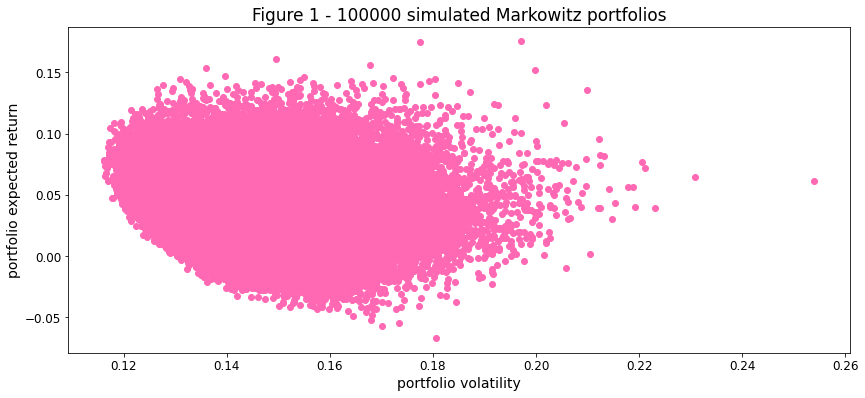

In [67]:
plt.scatter(portfolio_vol,portfolio_exp_returns, c="hotpink")
plt.xlabel("portfolio volatility", fontsize=14)
plt.ylabel("portfolio expected return", fontsize=14)
plt.title(f"Figure 1 - {num_of_simulated_portfolios} simulated Markowitz portfolios",fontsize =17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rcParams['figure.figsize'] = [14, 6]

It appears from Figure 1 that the Efficient Frontier does exist - we've answered question #1

----
Next we add all of the lists generated above to a DataFrame so, we can do more calculations.

In [56]:
final_df = {'Returns':portfolio_exp_returns,'Volatility':portfolio_vol}

for counter, symbol in enumerate(portfolio_df_1.columns.tolist()):
    final_df[symbol+ ' weight']=[w[counter] for w in port_weights]
    
portfolio_data = pd.DataFrame(final_df)
portfolio_data.head()


,Returns,Volatility,AAPL weight,BRK-A weight,ETN weight,GHC weight,GOOGL weight,GS weight,KO weight,MRK weight,MSGE weight,NEM weight
0,0.031402,0.155988,0.078186,0.053880,0.101597,0.098765,0.147304,0.143668,0.110327,0.028772,0.138860,0.098641
1,0.061423,0.144960,0.029311,0.150133,0.072926,0.135454,0.086406,0.133971,0.124198,0.016730,0.112591,0.138280
2,0.011629,0.145158,0.174148,0.000178,0.171637,0.046504,0.052391,0.198262,0.119208,0.028291,0.054081,0.155301
3,0.025001,0.137608,0.057748,0.100500,0.113923,0.124060,0.150179,0.095977,0.132030,0.100028,0.075523,0.050032
4,0.042936,0.135829,0.037389,0.124157,0.081392,0.123342,0.089033,0.146559,0.151503,0.065754,0.079844,0.101027


## The MSR portfolio weights

The MSR portfolio is the portfolio with the maximum Sharpe ration, which means that we need to calculate the Sharpe ratio. The Sharpe ratio measures how much return an investor can be expect for each incremental unit of risk, and thus can be used to compare portfolios with different levels of risk. The **Max Sharpe-Ratio (MSR)** portfolio is the portfolio with the highest Sharpe ratio. 

We calculate Sharpe Ratios using the following formula

*Sharpe Ratio = (Asset Return - Risk Free rate of return)/ Asset Volatility.*

We do this on the DataFrame and then sort by the Sharpe Ratio to get the MSR

In [57]:
#calculating Sharpe Ratio
riskfree_rate=0
portfolio_data['Sharpe'] = (portfolio_data['Returns']-riskfree_rate)/portfolio_data['Volatility']

#sort by Sharpe ration to get MSR portfolio
sorted_portfolio = portfolio_data.sort_values(by=['Sharpe'],ascending=False)
sorted_portfolio.head()

,Returns,Volatility,AAPL weight,BRK-A weight,ETN weight,GHC weight,GOOGL weight,GS weight,KO weight,MRK weight,MSGE weight,NEM weight,Sharpe
62513,0.153606,0.135887,0.002472,0.296814,0.002495,0.079010,0.015925,0.044997,0.094929,0.131515,0.009426,0.322418,1.130392
1238,0.144854,0.130956,0.010927,0.282829,0.006901,0.106224,0.006697,0.007242,0.100265,0.154833,0.106016,0.218067,1.106126
23632,0.139473,0.127618,0.100226,0.241334,0.001276,0.021063,0.033205,0.015732,0.192384,0.099690,0.009473,0.285619,1.092899
27710,0.136537,0.126373,0.002763,0.260666,0.016924,0.032489,0.015346,0.030328,0.150609,0.237579,0.019518,0.233780,1.080432
50282,0.161121,0.149581,0.007272,0.277304,0.030655,0.052077,0.013570,0.008218,0.100145,0.071710,0.179543,0.259505,1.077145


Next we note down these portfolio weights for use in our final shootout.

In [58]:
#we get the portfolio weights for MSR
MSR_weights = sorted_portfolio.iloc[0,2:-1]
MSR_weights = np.array(MSR_weights)
print(MSR_weights)

[0.0024717  0.29681361 0.00249501 0.07901039 0.01592494 0.04499713
 0.09492889 0.1315148  0.00942579 0.32241775]


Also we calculatget portfolio returns and Cumulative portfolio returns


In [59]:
#calculate MSR portfolio returns
msr_port_ret=portfolio_df_1_pctChg.iloc[:,0:numstocks].mul(MSR_weights,axis=1).sum(axis=1)
msr_cume_chg = (((msr_port_ret+1).cumprod()-1))

#percentage MSR Cumulative returns
msr_cume_chg_final = msr_cume_chg *100
print(msr_cume_chg_final.head())


Date
2021-01-04    0.000000
2021-01-05    0.053233
2021-01-06    1.675714
2021-01-07    2.300754
2021-01-08    1.476883
dtype: float64


## GMV Portfolio weights

The portfolio on the efficient frontier that has the least risk is the global minimum-variance (GMV) portfolio. The (GMV) portfolio actually tends to do pretty well over time, whereas the (MSR) portfolio tends to be rather inconsistent.

To get the GMV portfolio, all we need to do is sort by Volatility and extract those portfolio weights for the shootout

In [60]:
# Sort the portfolios by volatility
sorted_portfolios_gmv = portfolio_data.sort_values(by=['Volatility'], ascending=True)
print(sorted_portfolios_gmv.head())


#we get the portfolio weights for GMV
GMV_weights = sorted_portfolios_gmv.iloc[0,2:-1]
GMV_weights = np.array(GMV_weights)
print(GMV_weights)

        Returns  Volatility  AAPL weight  BRK-A weight  ETN weight  \
23633  0.078583    0.116175     0.090975      0.147304    0.021315   
48422  0.077516    0.116188     0.041920      0.132233    0.017039   
40693  0.073924    0.116294     0.050851      0.121264    0.063943   
82061  0.065665    0.116420     0.076297      0.022263    0.017670   
8748   0.068197    0.116599     0.064155      0.091305    0.070958   

       GHC weight  GOOGL weight  GS weight  KO weight  MRK weight  \
23633    0.053119      0.006508   0.079073   0.272826    0.189119   
48422    0.109204      0.038658   0.010999   0.288065    0.264859   
40693    0.120409      0.061067   0.026642   0.214639    0.192022   
82061    0.113734      0.035338   0.005186   0.373804    0.240174   
8748     0.128745      0.053227   0.032073   0.221291    0.183778   

       MSGE weight  NEM weight    Sharpe  
23633     0.016437    0.123324  0.676423  
48422     0.020473    0.076550  0.667164  
40693     0.002015    0.147147  0.6

In [61]:
#calculate GMV portfolio returns
GMV_port_ret=portfolio_df_1_pctChg.iloc[:,0:numstocks].mul(GMV_weights,axis=1).sum(axis=1)

#GMV Portfolio cumulative returns
GMV_cume_chg = (((GMV_port_ret+1).cumprod()-1))

#GMV Portfolio cumulative returns percentage
GMV_cume_chg_final = GMV_cume_chg *100
print(GMV_cume_chg_final.head())




Date
2021-01-04    0.000000
2021-01-05    0.022999
2021-01-06    0.392098
2021-01-07    1.167835
2021-01-08    1.284720
dtype: float64


## Equal Weighted and Benchmark

Now although we said, we're not going to calculate the equal weighted portfolio, we will for comparison's sake. Do the MSR and GMV portfolios perform better or worse than the Equal Weighted portfolios.

The Benchmark is also calculated in order to check performance.



In [62]:
#----------EQUAL WEIGHTED PORTFOLIO FOR COMPARISON-----------

#calulating portfolio weights for Equal Weighted Portfolio
numstocks = len(portfolio1)
EQW_portfolio_weights= np.repeat(1/numstocks, numstocks)

#calculate portfolio returns for Equal Weighted Portfolio
EQW_port_ret=portfolio_df_1_pctChg.iloc[:,0:numstocks].mul(EQW_portfolio_weights,axis=1).sum(axis=1)

#calculate cumulative returns for Equal Weighted Portfolio
EQW_cume_chg = ((EQW_port_ret+1).cumprod()-1)

#calculate percentage cumulative returns for Equal Weighted Portfolio
sj_EQW_cume_chg = (EQW_cume_chg)*100
print(sj_EQW_cume_chg)

#---------- Benchmark -----------

Symbol_bench=['SPY']
#get stock prices of benchmark  from yahoo
bench_df = yf.download(Symbol_bench,start=start,end=end)['Adj Close']
#calculate benchmark cume percentage change 
bench_cume_chg = ((bench_df.pct_change()+1).cumprod()-1)*100


Date
2021-01-04     0.000000
2021-01-05     0.269088
2021-01-06     1.800210
2021-01-07     3.069985
2021-01-08     2.928445
                ...    
2022-03-25    30.357917
2022-03-28    30.174239
2022-03-29    30.987990
2022-03-30    31.251354
2022-03-31    29.862879
Length: 314, dtype: float64
[*********************100%***********************]  1 of 1 completed


# SHOOTOUT 
We compare the returns on 3 versions of the Barron's 2021 portfolio vs the benchmark SPY 

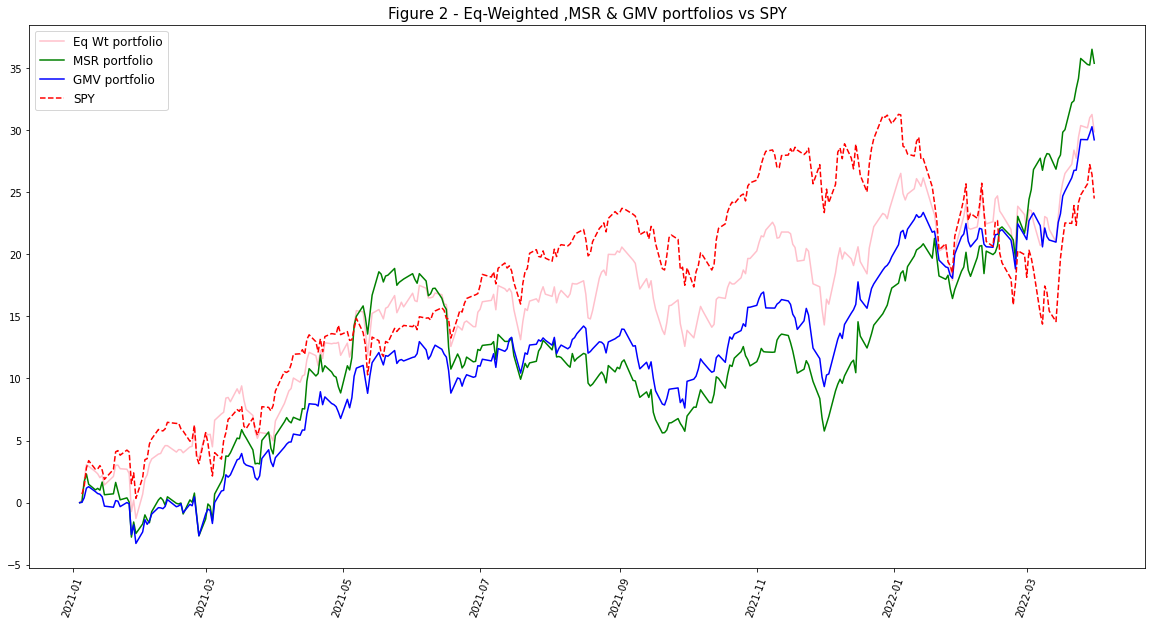

In [69]:
#ploting portfolios and benchmark
plt.plot(sj_EQW_cume_chg, color='pink',label = "Eq Wt portfolio")
plt.plot(msr_cume_chg_final, color='green',label = "MSR portfolio")
plt.plot(GMV_cume_chg_final, color='blue',label = "GMV portfolio")
plt.plot(bench_cume_chg,'--',color='red' ,label = "SPY")

plt.xticks(rotation=70)
plt.title("Figure 2 - Eq-Weighted ,MSR & GMV portfolios vs SPY",fontsize =15)
plt.legend(loc='upper left',prop={'size': 12})
plt.rcParams['figure.figsize'] = [20, 10]

## Conclusions

We posed 4 questions at the onset.

1.  Does the Efficient Frontier Emerge ?
> Yes, see Figure 1

2. Are the Barron's stock picks any good ?
> Not really, they only begin to beat the index SPY in the year 2022

3. In what 'style' of porfolio do the Barron's stock picks perform best -
> It seems that despite all this work, the Equal-Weighted portfolio is still the best performer.

4. Does the style of portfolio have any effect on the pick ?
> Not sure any conclusion can be drawn from the exercise above.
